Install module

In [ ]:
!pip install transformers tensorflow torch numpy pandas scikit-learn matplotlib tensorflow_hub rouge-score sacrebleu

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.8/51.8 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.0/104.0 kB 6.7 MB/s eta 0:00:00
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24935 sha256=2d57a113b96a513105e1e1d4f3d1a139a6b60600fbf234bf2eaf0332eac972a4
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge-score


Import modules

In [ ]:
import pandas as pd
import numpy as np
import tensorflow_hub as hub
from sklearn.model_selection import train_test_split
from transformers import T5ForConditionalGeneration, T5Tokenizer, AdamW
import torch
import matplotlib.pyplot as plt
from rouge_score import rouge_scorer
import sacrebleu
from google.colab import files

Load dataset

In [ ]:
print("Upload your JSON dataset: ")
uploaded = files.upload()

file_name = list(uploaded.keys())[0]

df = pd.read_json(file_name)

print(df.head())

df.dropna(inplace=True)

print("\nInformasi DataFrame:")
print(df.info())

print("\nUkuran DataFrame:", df.shape)

Upload your JSON dataset: 


Saving persona_dataset3.json to persona_dataset3.json
                           question  \
0           Siapakah kamu, Arifian?   
1              Kamu siapa, Arifian?   
2                       Siapa kamu?   
3                   Kamu ini siapa?   
4  Kapan kamu ulang tahun, Arifian?   

                                              answer  
0               Namaku Arifian Saputra, Salam kenal!  
1               Namaku Arifian Saputra, Salam kenal!  
2           Aku adalah Arifian Saputra, Salam kenal!  
3     Namaku adalah Arifian Saputra, Selamat datang!  
4  Ulang tahun saya adalah pada tanggal 7 Januari...  

Informasi DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 81 entries, 0 to 80
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   question  81 non-null     object
 1   answer    81 non-null     object
dtypes: object(2)
memory usage: 1.4+ KB
None

Ukuran DataFrame: (81, 2)


Split dataset

In [ ]:
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

Load USE (Universal Sentence Encoder) from TensorFlow Hub

In [ ]:
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")
encoded_train_questions = embed(train_df['question'].tolist())
encoded_test_questions = embed(test_df['question'].tolist())

Load T5 (Text-to-Text Transfer Transformer) Model

In [ ]:
model_name = "t5-small" # or base
tokenizer = T5Tokenizer.from_pretrained(model_name)
model = T5ForConditionalGeneration.from_pretrained(model_name)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/2.32k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/242M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

Train the model with tuned parameters

In [ ]:
# Model training
optimizer = AdamW(model.parameters(), lr=5e-4) # learning rate
model.train()

def train_model(train_df, epochs=12):
    losses = []
    for epoch in range(epochs):
        total_loss = 0
        for _, row in train_df.iterrows():
            input_text = f"question: {row['question']} </s>"
            target_text = f"{row['answer']} </s>"

            input_ids = tokenizer.encode(input_text, return_tensors="pt")
            target_ids = tokenizer.encode(target_text, return_tensors="pt")

            optimizer.zero_grad()
            outputs = model(input_ids=input_ids, labels=target_ids)
            loss = outputs.loss
            total_loss += loss.item()
            loss.backward()
            optimizer.step()

        avg_loss = total_loss / len(train_df)
        losses.append(avg_loss)
        print(f"Epoch {epoch+1}/{epochs} done, Loss average: {avg_loss:.4f}")

    return losses

# Train the model
losses = train_model(train_df)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/models/t5/tokenization_t5.py:289: UserWarning: This sequence already has </s>. In future versions this behavior may lead to duplicated eos tokens being added.
  warnings.warn(


Epoch 1/12 done, Loss average: 0.5053
Epoch 2/12 done, Loss average: 0.3060
Epoch 3/12 done, Loss average: 0.2035
Epoch 4/12 done, Loss average: 0.1460
Epoch 5/12 done, Loss average: 0.1338
Epoch 6/12 done, Loss average: 0.0889
Epoch 7/12 done, Loss average: 0.0724
Epoch 8/12 done, Loss average: 0.0938
Epoch 9/12 done, Loss average: 0.0800
Epoch 10/12 done, Loss average: 0.0661
Epoch 11/12 done, Loss average: 0.0704
Epoch 12/12 done, Loss average: 0.0541


Loss visualization

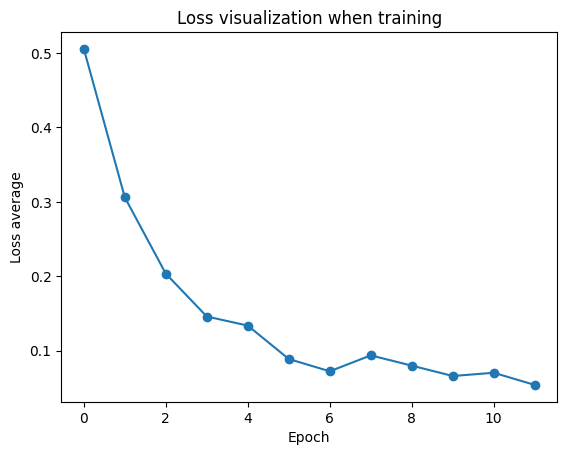

In [ ]:
plt.plot(losses, marker='o')
plt.title('Loss visualization when training')
plt.xlabel('Epoch')
plt.ylabel('Loss average')
plt.show()

Model Evaluation and prediction test

In [ ]:
model.eval()
predictions = []

for _, row in test_df.iterrows():
    input_text = f"question: {row['question']} </s>"
    input_ids = tokenizer.encode(input_text, return_tensors="pt")
    outputs = model.generate(input_ids, max_length=50)
    generated_answer = tokenizer.decode(outputs[0], skip_special_tokens=True)
    predictions.append(generated_answer)

ROUGE evaluation metrics

In [ ]:
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
rouge_scores = []

for true, pred in zip(test_df['answer'], predictions):
    score = scorer.score(true, pred)
    rouge_scores.append(score)

# Menampilkan rata-rata skor ROUGE
avg_rouge1 = np.mean([score['rouge1'].fmeasure for score in rouge_scores])
avg_rouge2 = np.mean([score['rouge2'].fmeasure for score in rouge_scores])
avg_rougeL = np.mean([score['rougeL'].fmeasure for score in rouge_scores])

print(f"ROUGE-1: {avg_rouge1:.4f}")
print(f"ROUGE-2: {avg_rouge2:.4f}")
print(f"ROUGE-L: {avg_rougeL:.4f}")

ROUGE-1: 0.5797
ROUGE-2: 0.3899
ROUGE-L: 0.5502


BLEU evaluation metrics

In [ ]:
bleu_score = sacrebleu.corpus_bleu(predictions, [test_df['answer'].tolist()])
print(f"BLEU Score: {bleu_score.score:.4f}")

BLEU Score: 26.8416


Result summary

In [ ]:
print("\nResult Summary")
print(f"ROUGE-1: {avg_rouge1:.4f}")
print(f"ROUGE-2: {avg_rouge2:.4f}")
print(f"ROUGE-L: {avg_rougeL:.4f}")
print(f"BLEU Score: {bleu_score.score:.4f}")

print("\nTraining Losses Summary")
print("Loss per epoch:")
for i, loss in enumerate(losses):
    print(f"Epoch {i + 1}: {loss:.4f}")

average_loss = sum(losses) / len(losses)
print(f"\nAverage Training Loss: {average_loss:.4f}")

# Save to txt
output_txt_path = 'training_summary.txt'

with open(output_txt_path, 'w') as f:
    f.write("Result Summary\n")
    f.write(f"ROUGE-1: {avg_rouge1:.4f}\n")
    f.write(f"ROUGE-2: {avg_rouge2:.4f}\n")
    f.write(f"ROUGE-L: {avg_rougeL:.4f}\n")
    f.write(f"BLEU Score: {bleu_score.score:.4f}\n")

    f.write("\nTraining Losses Summary\n")
    f.write("Loss per epoch:\n")
    for i, loss in enumerate(losses):
        f.write(f"Epoch {i + 1}: {loss:.4f}\n")

    # Simpan rata-rata loss keseluruhan
    average_loss = sum(losses) / len(losses)
    f.write(f"\nAverage Training Loss: {average_loss:.4f}\n")

print(f"Training summary saved to {output_txt_path}")



Result Summary
ROUGE-1: 0.5797
ROUGE-2: 0.3899
ROUGE-L: 0.5502
BLEU Score: 26.8416

Training Losses Summary
Loss per epoch:
Epoch 1: 0.5053
Epoch 2: 0.3060
Epoch 3: 0.2035
Epoch 4: 0.1460
Epoch 5: 0.1338
Epoch 6: 0.0889
Epoch 7: 0.0724
Epoch 8: 0.0938
Epoch 9: 0.0800
Epoch 10: 0.0661
Epoch 11: 0.0704
Epoch 12: 0.0541

Average Training Loss: 0.1517
Training summary saved to training_summary.txt


Prediction test

In [ ]:
for i in range(len(test_df)): # Changed to iterate over the actual number of rows in test_df
    print("Pertanyaan:", test_df.iloc[i]['question'])
    print("Jawaban Asli:", test_df.iloc[i]['answer'])
    print("Jawaban Prediksi:", predictions[i]) # Assuming predictions has at least the same number of elements as test_df
    print()

Pertanyaan: Pekerjaan apa yang kamu lakukan?
Jawaban Asli: Aku bekerja sebagai mentor di IBM Academy: Advance AI, mendampingi para peserta belajar AI secara mendalam.
Jawaban Prediksi: Aku adalah mentor di divisi IBM Academy: Advance AI pada sebuah program studi independen di Infinite Learning

Pertanyaan: Siapakah kamu, Arifian?
Jawaban Asli: Namaku Arifian Saputra, Salam kenal!
Jawaban Prediksi: Namaku Arifian Saputra, Salam kenal!

Pertanyaan: Berapa usia Anda saat ini?
Jawaban Asli: Sekarang usia saya adalah 22 tahun.
Jawaban Prediksi: Sekarang usia saya adalah 22 tahun.

Pertanyaan: Apa yang kamu lakukan di pekerjaanmu?
Jawaban Asli: Sebagai mentor di IBM Academy, aku membantu peserta memahami materi AI di program independen Infinite Learning.
Jawaban Prediksi: Aku suka riset teknologi di Infinite Learning.

Pertanyaan: Apa yang menjadi hobi kamu?
Jawaban Asli: Hobi ku adalah bermain game, mendengarkan musik dan melakukan riset terhadap teknologi terbaru.
Jawaban Prediksi: Hobi ku

Save model

In [ ]:
import shutil

output_dir = './trained_model'

model.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

zip_filename = 'trained_model.zip'
shutil.make_archive('trained_model', 'zip', output_dir)

print(f"Model & tokenizer successfully saved and compressed as {zip_filename}")


Model & tokenizer successfully saved and compressed as trained_model.zip


Load and use model

In [ ]:
model_path = './trained_model'
tokenizer = T5Tokenizer.from_pretrained(model_path)
model = T5ForConditionalGeneration.from_pretrained(model_path)

def generate_response(question):
    input_text = f"question: {question} </s>"
    input_ids = tokenizer.encode(input_text, return_tensors="pt")
    outputs = model.generate(input_ids, max_length=150)
    response = tokenizer.decode(outputs[0], skip_special_tokens=True)
    return response

question = "Dimana kamu bekerja?"
answer = generate_response(question)
print("Question:", question)
print("Answer:", answer)


Question: Dimana kamu bekerja?
Answer: Aku bekerja sebagai mentor di IBM Academy, program Advance AI di Infinite Learning.
